## 로이터 뉴스 분류하기 - LSTM
- 케라스에서 데이터셋 불러온다.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
import warnings
warnings.filterwarnings('ignore')

In [2]:
(X_train, y_train), (X_test, y_test) = reuters.load_data() # 튜플로 받는다.

2121728/2110848 [==============================] - 0s 0us/step


In [3]:
# 데이터 갯수
len(X_train), len(X_test)

(8982, 2246)

In [4]:
#카테고리 갯수
max(y_train) + 1

46

In [5]:
# 첫번째 뉴스
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
type(reuters.get_word_index()), reuters.get_word_index()['the']

565248/550378 [==============================] - 0s 0us/step


(dict, 1)

In [7]:
index_word = {}
for key, value in reuters.get_word_index().items():
    index_word[value] = key
len(index_word)
# value와 키를 바꿈

30979

In [8]:
# 첫번째 기사 복원
' '.join(index_word[index] for index in X_train[0])
# 파이썬에서 많이 사용/ 리스트 표현식, join은 꼭 기억해라

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [9]:
# 뉴스 기사의 길이
print('뉴스 최대길이: ', max(len(s) for s in X_train))
print('뉴스 평균길이: ', sum(map(len, X_train)) /len(X_train)) #len함수를 매핑해서 합을 도출

뉴스 최대길이:  2376
뉴스 평균길이:  145.5398574927633


In [10]:
x = [[1,2,3],[4,5,6,7],[8,9]]
list(map(len, x))
sum(map(len, x))

9

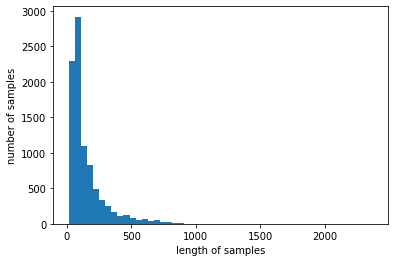

In [11]:
# 대부분의 기사는 앞쪽에 있다
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

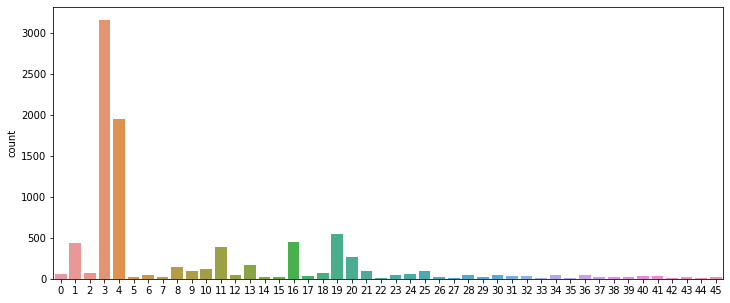

In [12]:
plt.figure(figsize=(12,5))
sns.countplot(y_train);

In [13]:
# 데이터가 0에서 45까지 있다. 분포가 고르지 못하고 3,4기사 압도적으로 많음

### LSTM으로 로이터 뉴스 분류
- 단어 : 빈도수 기준 1,000 단어 (총 단어수: 30,979)
- 길이 : 100단어까지 (최대 2,376)  
- LSTM에서는 단어의 갯수를 맞춰 진행해야된다.

In [14]:
num_words = 1000
max_len = 100

In [15]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [17]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = num_words,  test_split = 0.2)
# 미리 문장길이를 제한 하지 말고 다 뽑아 놓고 pad_sequences에서 뽑아라
# max_len을 100으로 설정했기 때문에 뉴스의 길이가 50이면 100을 안넘어서 설정이 안됨. 짧은 문장은 0padding 긴 문장은 짤리고

In [18]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen= max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

- 모델 정의/설정/학습

In [19]:
embedding_dim = 128
hidden_units = 128
num_classes = 46


In [20]:
model = Sequential([
                    Embedding(num_words, embedding_dim, input_length = max_len),
                    LSTM(hidden_units),
                    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          128000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 46)                5934      
                                                                 
Total params: 265,518
Trainable params: 265,518
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])


In [22]:
model_path = 'best-reuters-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only= True, verbose = 1 )
es = EarlyStopping(patience= 5)

In [23]:
hist = model.fit(
    X_train, Y_train ,epochs = 30, batch_size=128,
    validation_split = 0.2, callbacks=[mc, es]
)

Epoch 1/30
57/57 [==============================] - ETA: 0s - loss: 2.6760 - accuracy: 0.3354
Epoch 00001: val_loss improved from inf to 2.31994, saving model to best-reuters-lstm.h5
57/57 [==============================] - 12s 66ms/step - loss: 2.6760 - accuracy: 0.3354 - val_loss: 2.3199 - val_accuracy: 0.3450
Epoch 2/30
56/57 [============================>.] - ETA: 0s - loss: 2.0393 - accuracy: 0.4598
Epoch 00002: val_loss improved from 2.31994 to 1.94407, saving model to best-reuters-lstm.h5
57/57 [==============================] - 2s 41ms/step - loss: 2.0391 - accuracy: 0.4597 - val_loss: 1.9441 - val_accuracy: 0.4953
Epoch 3/30
56/57 [============================>.] - ETA: 0s - loss: 1.8838 - accuracy: 0.5013
Epoch 00003: val_loss improved from 1.94407 to 1.88775, saving model to best-reuters-lstm.h5
57/57 [==============================] - 2s 35ms/step - loss: 1.8836 - accuracy: 0.5012 - val_loss: 1.8878 - val_accuracy: 0.3973
Epoch 4/30
55/57 [===========================>..] - 

In [25]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 2s 12ms/step - loss: 1.3044 - accuracy: 0.6825


[1.3043806552886963, 0.6825467348098755]

- case 2) : max_len이 300일 경우

In [26]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words = num_words,  test_split = 0.2)

In [27]:
max_len = 300
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen= max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 300), (2246, 300), (8982, 46), (2246, 46))

In [28]:
model2 = Sequential([
                    Embedding(num_words, embedding_dim, input_length = max_len),
                    LSTM(hidden_units),
                    Dense(num_classes, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          128000    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 46)                5934      
                                                                 
Total params: 265,518
Trainable params: 265,518
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_path = 'best-reuters-lstm.h5'
mc = ModelCheckpoint(model_path, save_best_only= True, verbose = 1 )
es = EarlyStopping(patience= 10)

In [30]:
model2.compile('adam', 'categorical_crossentropy', ['accuracy'])


In [31]:
hist = model2.fit(
    X_train, Y_train ,epochs = 50, batch_size=128,
    validation_split = 0.2, callbacks=[mc, es]
)

Epoch 1/50
57/57 [==============================] - ETA: 0s - loss: 2.6729 - accuracy: 0.3470
Epoch 00001: val_loss improved from inf to 2.42792, saving model to best-reuters-lstm.h5
57/57 [==============================] - 8s 85ms/step - loss: 2.6729 - accuracy: 0.3470 - val_loss: 2.4279 - val_accuracy: 0.3450
Epoch 2/50
57/57 [==============================] - ETA: 0s - loss: 2.2145 - accuracy: 0.4420
Epoch 00002: val_loss improved from 2.42792 to 2.09838, saving model to best-reuters-lstm.h5
57/57 [==============================] - 4s 73ms/step - loss: 2.2145 - accuracy: 0.4420 - val_loss: 2.0984 - val_accuracy: 0.4691
Epoch 3/50
56/57 [============================>.] - ETA: 0s - loss: 2.0316 - accuracy: 0.4961
Epoch 00003: val_loss improved from 2.09838 to 2.01480, saving model to best-reuters-lstm.h5
57/57 [==============================] - 4s 74ms/step - loss: 2.0313 - accuracy: 0.4962 - val_loss: 2.0148 - val_accuracy: 0.4853
Epoch 4/50
57/57 [==============================] - E

In [32]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 2s 20ms/step - loss: 1.1171 - accuracy: 0.7400


[1.1171225309371948, 0.7399821877479553]